In [1]:
from imports import *
from utils import *
from tfms_torch import *
from tfms_albumentations import get_tfms_albu, apply_tfms_albu
from video_dataset import *
from samplers import *

## Create Training and Validation Datasets

In [2]:
data_dir = Path('/home/rahul/datasets/tennis-func/')
cache_dir = data_dir/'.cache'

In [3]:
cache_dir.ls()

['train-metrics',
 'train_fpc-32_sc-1_sf-2_rsz-2',
 'valid_fpc-32_sc-1_sf-2_rsz-1',
 'valid_fpc-32_sc-1_sf-2_rsz-2',
 'train_fpc-32_sc-1_sf-2_rsz-1']

In [4]:
train_data = torch.load(cache_dir/'train_fpc-32_sc-1_sf-2_rsz-1')
valid_data = torch.load(cache_dir/'valid_fpc-32_sc-1_sf-2_rsz-1')

In [5]:
def get_data(data_dir, fpclip=32, step_clips=1, step_frames=2, rsz_fct=2, albu_p=0.5):
    train_data = VideoDataset(data_dir/'train',
                              frames_per_clip    = fpclip,
                              step_between_clips = step_clips,
                              frame_stride = step_frames,
                              tfms_torch   = get_tfms_torch(resize_fct=rsz_fct),
                              tfms_albu    = get_tfms_albu(p=albu_p))
    valid_data = VideoDataset(data_dir/'valid',
                              frames_per_clip    = fpclip,
                              step_between_clips = step_clips,
                              frame_stride = step_frames,
                              tfms_torch   = get_tfms_torch(resize_fct=rsz_fct))
    return train_data, valid_data

## Data Loaders

In [6]:
from torch.utils.data import DataLoader as DataLoader

In [7]:
train_sampler = FirstClipSampler(train_data.video_clips, 2)
valid_sampler = FirstClipSampler(valid_data.video_clips, 2)
bs = 8

In [8]:
def get_dls(train_data, valid_data,
            train_sampler=FirstClipSampler(train_data.video_clips, 2),
            valid_sampler=FirstClipSampler(valid_data.video_clips, 2),
            bs=32, collate_fn=collate_fn):
    
    train_dl = DataLoader(train_data, batch_size=bs, sampler=train_sampler, collate_fn=collate_fn)
    valid_dl = DataLoader(valid_data, batch_size=bs, sampler=valid_sampler, collate_fn=collate_fn)
    
    return train_dl, valid_dl

In [9]:
train_dl, valid_dl = get_dls(train_data, valid_data, bs=bs)

In [10]:
x,y = next(iter(train_dl))
x.shape, y.shape

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


(torch.Size([8, 3, 10, 128, 227]), torch.Size([8]))

## LR Finder

In [11]:
from torch_lr_finder import LRFinder

/home/rahul/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [27]:
model = torchvision.models.video.r2plus1d_18(pretrained=True)
#model = model.half()
model = model.cuda()

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-2)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


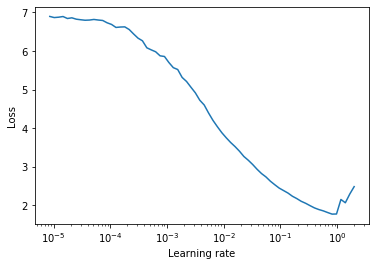

In [15]:
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(train_dl, end_lr=10, num_iter=90)
lr_finder.plot()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


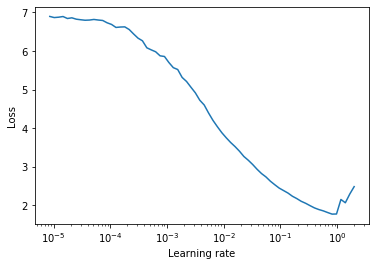

In [15]:
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(train_dl, end_lr=10, num_iter=90)
lr_finder.plot()

In [29]:
torch.cuda.empty_cache()

## Training

### Helper Functions

In [15]:
from visionmod import train_utils as utils
import datetime
import time

In [16]:
def train_one_epoch(model, criterion, optimizer, lr_scheduler, data_loader, device, epoch, print_freq, apex=False):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value}'))
    metric_logger.add_meter('clips/s', utils.SmoothedValue(window_size=10, fmt='{value:.3f}'))

    header = 'Epoch: [{}]'.format(epoch)
    for video, target in metric_logger.log_every(data_loader, print_freq, header):
        start_time = time.time()
        video, target = video.to(device), target.to(device)
        output = model(video)
        loss = criterion(output, target)

        optimizer.zero_grad()
        if apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        optimizer.step()

        acc1, acc5 = utils.accuracy(output, target, topk=(1, 5))
        batch_size = video.shape[0]
        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
        metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
        metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
        metric_logger.meters['clips/s'].update(batch_size / (time.time() - start_time))
        lr_scheduler.step()

In [17]:
def evaluate(model, criterion, data_loader, device):
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    with torch.no_grad():
        for video, target in metric_logger.log_every(data_loader, 100, header):
            video = video.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(video)
            loss = criterion(output, target)

            acc1, acc5 = utils.accuracy(output, target, topk=(1, 5))
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            batch_size = video.shape[0]
            metric_logger.update(loss=loss.item())
            metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
            metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()

    print(' * Clip Acc@1 {top1.global_avg:.3f} Clip Acc@5 {top5.global_avg:.3f}'
          .format(top1=metric_logger.acc1, top5=metric_logger.acc5))
    return metric_logger.acc1.global_avg

### Training

In [30]:
lr=1e-2
optim = torch.optim.Adam(model.parameters(), lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optim, max_lr=5e-1, steps_per_epoch=len(train_dl), epochs=1
)

device = torch.device('cuda')

In [31]:
metrics_dir = cache_dir/'train-metrics'

In [ ]:
start_time = time.time()

for epoch in range(10):
    train_one_epoch(model, criterion, optim, lr_scheduler, train_dl, device, epoch, print_freq=100)
    evaluate(model, criterion, valid_dl, device)
    checkpoint = {
        'model': model_without_ddp.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
        'args': args}
    utils.save_on_master(
        checkpoint,
        os.path.join(str(metrics_dir), 'model_{}.pth'.format(epoch)))
    utils.save_on_master(
        checkpoint,
        os.path.join(str(metrics_dir), 'checkpoint.pth'))
    
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


Epoch: [0]  [  0/556]  eta: 0:45:32  lr: 0.020000000000000018  clips/s: 12.236  loss: 6.9128 (6.9128)  acc1: 0.0000 (0.0000)  acc5: 12.5000 (12.5000)  time: 4.9138  data: 4.2599  max mem: 5949
